In [1]:
import numpy as np 
import pandas as pd 
pd.options.mode.chained_assignment = None
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import LabelEncoder 
from xgboost import XGBClassifier
import re #Regular expressions
import nltk
from nltk import word_tokenize
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df=pd.read_csv("/kaggle/input/sentiment-analysis/sentiment_analysis.csv")

In [3]:
df.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook
2,2017,8,18,night,Don't angry me,negative,Facebook
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram


In [4]:
df.shape

(499, 7)

In [5]:
df['text'].isnull().value_counts()


text
False    499
Name: count, dtype: int64

In [6]:
df['sentiment'].isnull().value_counts()

sentiment
False    499
Name: count, dtype: int64

In [7]:
df['sentiment'].unique()

array(['positive', 'negative', 'neutral'], dtype=object)

###  Custom Word Clouds Based on Sentiment

In [8]:

def wordcloud(type, color, background_color):
    
    sentiment_type = df[df["sentiment"] == type]["text"].tolist()
    
    if not sentiment_type:
        print(f"No text found for sentiment type '{type}'.")
        return
    
    word_cloud_text = ' '.join(sentiment_type)
    
    wordcloud = WordCloud(
        max_font_size=100,
        max_words=100,
        background_color=background_color,
        colormap=color,
        width=800,
        height=800
    ).generate(word_cloud_text)

    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


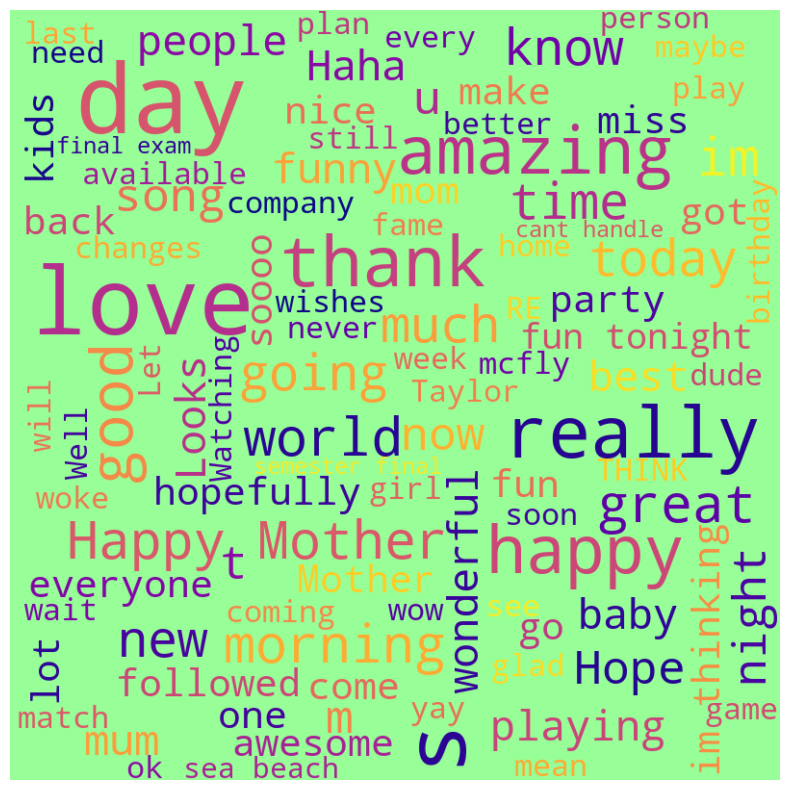

In [9]:
wordcloud("positive", "plasma", "#98FF98")

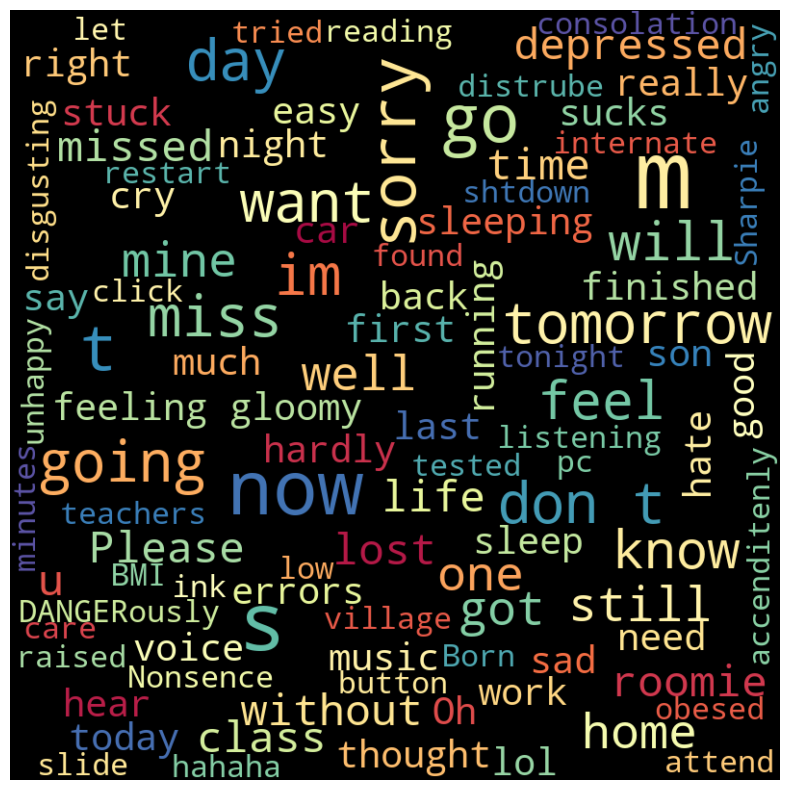

In [10]:
wordcloud("negative", "Spectral", "black") 

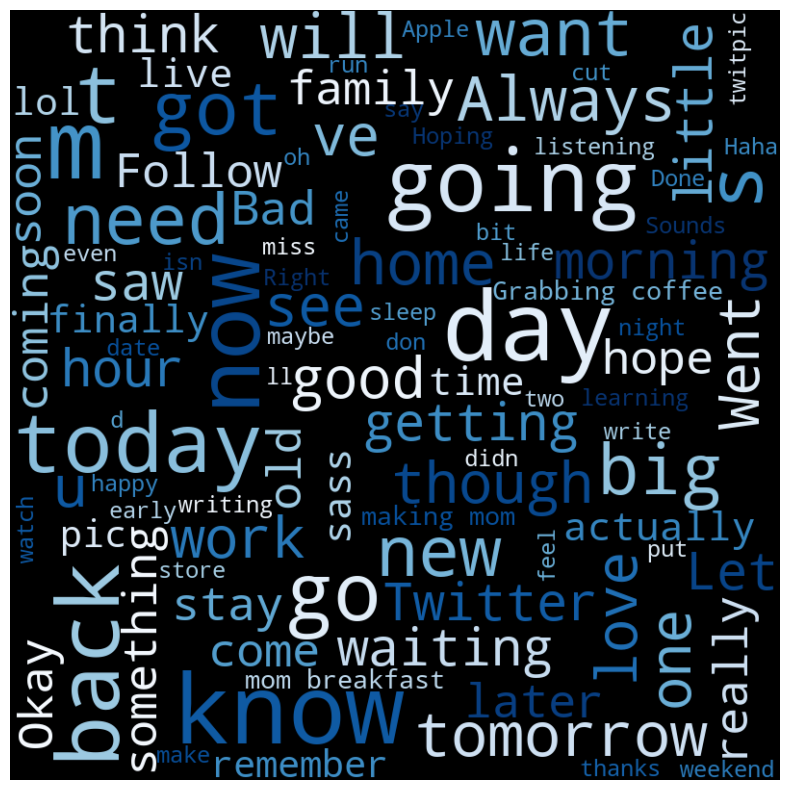

In [11]:
wordcloud("neutral", "Blues", "black") 

##  Text Analysis

In [12]:
word_tokenize(df.text[0])

['What', 'a', 'great', 'day', '!', '!', '!', 'Looks', 'like', 'dream', '.']

In [13]:
tokens_text = [word_tokenize(str(line)) for line in df.text]


In [14]:
tokens_text[1]

['I',
 'feel',
 'sorry',
 ',',
 'I',
 'miss',
 'you',
 'here',
 'in',
 'the',
 'sea',
 'beach']

In [15]:
tokens_counter = [word for l in tokens_text for word in l]    #Unique word counter
print("Number of tokens: ", len(set(tokens_counter)))

Number of tokens:  1676


In [16]:
stopwords_nltk = nltk.corpus.stopwords
stop_words = stopwords_nltk.words('english')
stop_words[:5]

['i', 'me', 'my', 'myself', 'we']

### Bag of Words

In [17]:

bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=stop_words, 
    ngram_range=(1, 5) 
)

In [18]:
X_train, X_test = train_test_split(df, test_size=0.1, random_state=0)

In [19]:

X_train_bow = bow_counts.fit_transform(X_train.text)

X_test_bow = bow_counts.transform(X_test.text)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [20]:
X_train_bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 13896 stored elements and shape (449, 9485)>

In [21]:
X_test_bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 666 stored elements and shape (50, 9485)>

In [22]:
y_train_bow = X_train['sentiment']
y_test_bow = X_test['sentiment']


In [23]:
y_train_bow.value_counts() / y_train_bow.shape[0]

sentiment
neutral     0.389755
positive    0.336303
negative    0.273942
Name: count, dtype: float64

## Logistic Regression Model

In [24]:
model1 = LogisticRegression(C=1, solver="liblinear", max_iter=200)
model1.fit(X_train_bow, y_train_bow)

test_pred = model1.predict(X_test_bow)
print("Accuracy: ", accuracy_score(y_test_bow, test_pred) * 100)

Accuracy:  74.0


# XGBoost 



In [25]:
le = LabelEncoder()
y_train_bow_label = le.fit_transform(y_train_bow)
y_test_bow_label=le.transform(y_test_bow)


In [26]:
%%time
XGB=XGBClassifier(objective="multi:softmax",n_estimators=1500,colsample_bytree=0.3, subsample=0.7)
XGB.fit(X_train_bow, y_train_bow_label)

test_pred_2 = XGB.predict(X_test_bow)
print("Accuracy: ", accuracy_score(y_test_bow_label, test_pred_2) * 100)

Accuracy:  72.0
CPU times: user 32 s, sys: 365 ms, total: 32.4 s
Wall time: 8.64 s
